In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=50000, shuffle=False)  # Load all images at once

# Calculate mean and std
data = next(iter(train_loader))[0]  # Get all images as a single tensor
mean = data.mean(dim=[0, 2, 3])  # Mean across batch, height, and width
std = data.std(dim=[0, 2, 3])    # Std across batch, height, and width

print(f"Mean: {mean}")
print(f"Std: {std}")


100%|██████████| 170M/170M [00:02<00:00, 61.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


Using device: cpu
Files already downloaded and verified
Files already downloaded and verified

--- Training Baseline CNN (1a) ---
Epoch 1, Loss: 1.4388
Epoch 2, Loss: 1.0994
Epoch 3, Loss: 0.9527
Epoch 4, Loss: 0.8661
Epoch 5, Loss: 0.7987
Epoch 6, Loss: 0.7406
Epoch 7, Loss: 0.6966
Epoch 8, Loss: 0.6533
Epoch 9, Loss: 0.6140
Epoch 10, Loss: 0.5793
Epoch 11, Loss: 0.5437
Epoch 12, Loss: 0.5145
Epoch 13, Loss: 0.4846
Epoch 14, Loss: 0.4552
Epoch 15, Loss: 0.4335
Epoch 16, Loss: 0.4023
Epoch 17, Loss: 0.3810
Epoch 18, Loss: 0.3541
Epoch 19, Loss: 0.3359
Epoch 20, Loss: 0.3141
Epoch 21, Loss: 0.2977
Epoch 22, Loss: 0.2779
Epoch 23, Loss: 0.2575
Epoch 24, Loss: 0.2437
Epoch 25, Loss: 0.2365
Epoch 26, Loss: 0.2138
Epoch 27, Loss: 0.2017
Epoch 28, Loss: 0.1955
Epoch 29, Loss: 0.1832
Epoch 30, Loss: 0.1707
Epoch 31, Loss: 0.1641
Epoch 32, Loss: 0.1543
Epoch 33, Loss: 0.1461
Epoch 34, Loss: 0.1431
Epoch 35, Loss: 0.1327
Epoch 36, Loss: 0.1388
Epoch 37, Loss: 0.1193
Epoch 38, Loss: 0.1203
Epoch

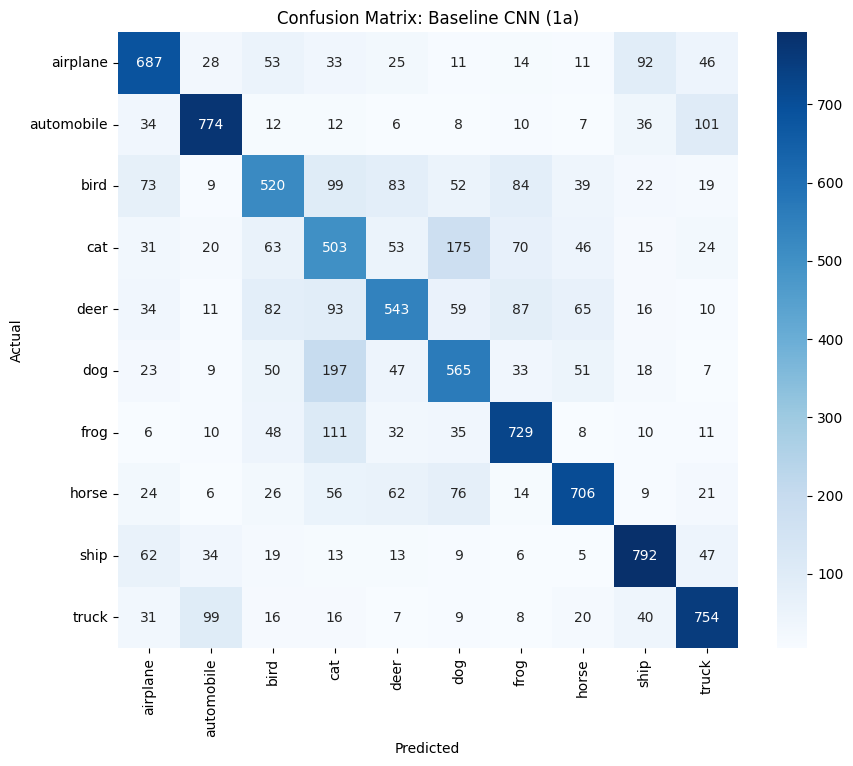

In [ ]:
# Required Imports
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CIFAR-10 Dataset Preparation
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Baseline CNN Model
class CNNBaseline(nn.Module):
    def __init__(self):
        super(CNNBaseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 32, 64)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 32)
        x = self.act3(self.fc1(x))
        x = self.fc2(x)
        return x

# Train and Evaluate Baseline CNN
model = CNNBaseline().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Timing the Training Process
start_time = time.time()  # Start timer

print("\n--- Training Baseline CNN (1a) ---")
for epoch in range(200):  # Modify the number of epochs if needed
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

# End timer
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

# Evaluation
model.eval()
correct = 0
total = 0
predictions, true_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Baseline CNN (1a) Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix: Baseline CNN (1a)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Using device: cpu


100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

--- Training Extended CNN (1b) ---
Epoch 1, Loss: 1.4432
Epoch 2, Loss: 1.0581
Epoch 3, Loss: 0.8959
Epoch 4, Loss: 0.7872
Epoch 5, Loss: 0.7063
Epoch 6, Loss: 0.6349
Epoch 7, Loss: 0.5795
Epoch 8, Loss: 0.5159
Epoch 9, Loss: 0.4621
Epoch 10, Loss: 0.4207
Epoch 11, Loss: 0.3792
Epoch 12, Loss: 0.3304
Epoch 13, Loss: 0.2991
Epoch 14, Loss: 0.2630
Epoch 15, Loss: 0.2376
Epoch 16, Loss: 0.2147
Epoch 17, Loss: 0.1893
Epoch 18, Loss: 0.1744
Epoch 19, Loss: 0.1590
Epoch 20, Loss: 0.1525
Epoch 21, Loss: 0.1309
Epoch 22, Loss: 0.1249
Epoch 23, Loss: 0.1263
Epoch 24, Loss: 0.1092
Epoch 25, Loss: 0.1116
Epoch 26, Loss: 0.1073
Epoch 27, Loss: 0.1023
Epoch 28, Loss: 0.1061
Epoch 29, Loss: 0.0967
Epoch 30, Loss: 0.0947
Epoch 31, Loss: 0.0896
Epoch 32, Loss: 0.0915
Epoch 33, Loss: 0.0875
Epoch 34, Loss: 0.0827
Epoch 35, Loss: 0.0846
Epoch 36, Loss: 0.0812
Epoch 37, Loss: 0.0828
Epoch 38, Loss: 0.0790
Epoch 39, 

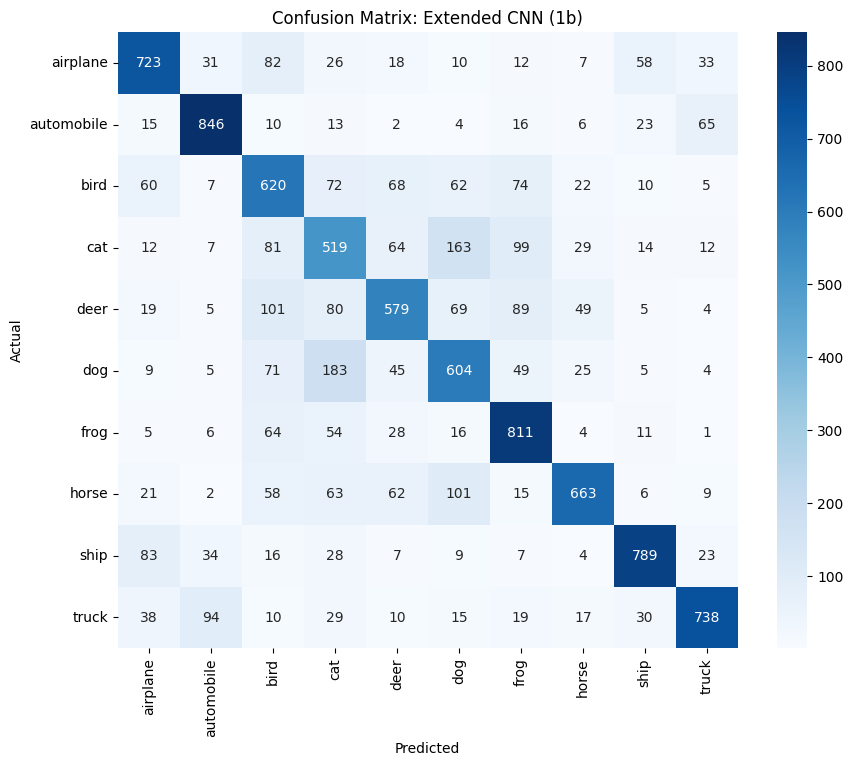

In [ ]:
# Required Imports
import time  # For timing the training process
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CIFAR-10 Dataset Preparation
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Extended CNN Model
class CNNExtended(nn.Module):
    def __init__(self):
        super(CNNExtended, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 4 * 64, 128)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(-1, 4 * 4 * 64)
        x = self.act4(self.fc1(x))
        x = self.fc2(x)
        return x

# Train and Evaluate Extended CNN
model = CNNExtended().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Timing the Training Process
start_time = time.time()  # Start timer

print("\n--- Training Extended CNN (1b) ---")
for epoch in range(200):  # Set epochs to 200
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

# End timer
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time:.2f} seconds")

# Evaluation
model.eval()
correct = 0
total = 0
predictions, true_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Extended CNN (1b) Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix: Extended CNN (1b)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
